In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import seaborn as sns
import numpy as np

C:\Users\Adarsh Sharma\AppData\Local\Temp\ipykernel_47548\2309945412.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Load the dataset
file_path = 'continuous dataset.csv'  # Update the file path as needed
data = pd.read_csv(file_path)

In [3]:
# Convert the 'datetime' column to a datetime format
data['datetime'] = pd.to_datetime(data['datetime'], format='%d-%m-%Y %H:%M')

In [4]:
# Extracting date and time features
data['hour'] = data['datetime'].dt.hour
data['day_of_week'] = data['datetime'].dt.dayofweek
data['month'] = data['datetime'].dt.month

In [5]:
# Create lag features for 'nat_demand'
for lag in range(1, 25):  # Creating lag features for the past 24 hours
    data[f'nat_demand_lag_{lag}'] = data['nat_demand'].shift(lag)

In [6]:
# Create rolling statistics features for 'nat_demand'
data['rolling_mean_24h'] = data['nat_demand'].rolling(window=24).mean()
data['rolling_std_24h'] = data['nat_demand'].rolling(window=24).std()

In [7]:
# Drop rows with NaN values created due to lag and rolling features
data = data.dropna()

In [8]:
# Feature preparation for clustering
features_for_clustering = data[['T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 
                                'T2M_san', 'QV2M_san', 'TQL_san', 'W2M_san', 
                                'T2M_dav', 'QV2M_dav', 'TQL_dav', 'W2M_dav', 
                                'hour', 'day_of_week', 'month']]


In [9]:

# Apply KMeans clustering
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=5, random_state=42)
data['cluster'] = kmeans.fit_predict(features_for_clustering)

In [10]:
# Prepare the data for modeling
X = data.drop(columns=['datetime', 'nat_demand'])
y = data['nat_demand']

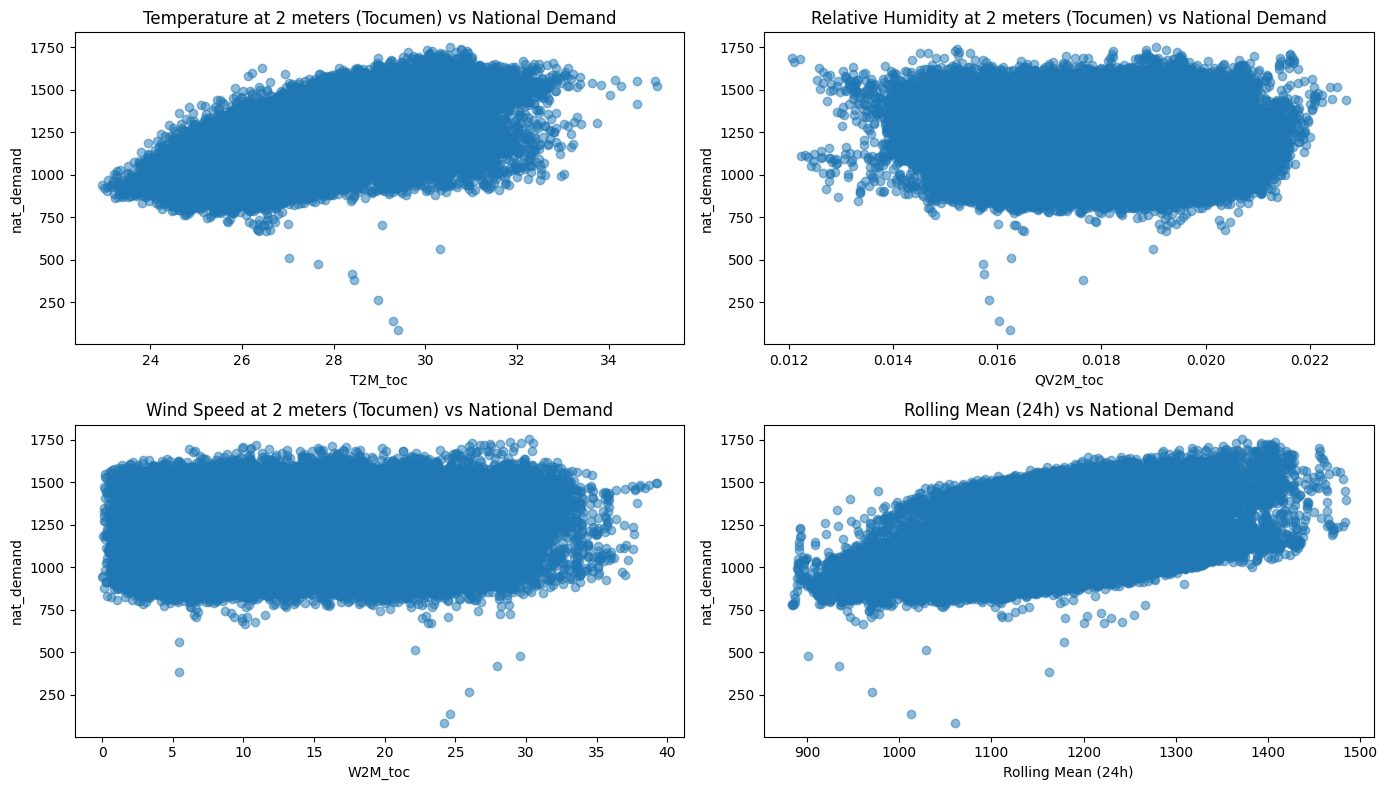

In [11]:
# Graphical Representation
# 1. Scatter Plot between nat_demand and a few features
plt.figure(figsize=(14, 8))

# Temperature at 2 meters vs nat_demand
plt.subplot(2, 2, 1)
plt.scatter(data['T2M_toc'], data['nat_demand'], alpha=0.5)
plt.title('Temperature at 2 meters (Tocumen) vs National Demand')
plt.xlabel('T2M_toc')
plt.ylabel('nat_demand')

# Relative Humidity at 2 meters vs nat_demand
plt.subplot(2, 2, 2)
plt.scatter(data['QV2M_toc'], data['nat_demand'], alpha=0.5)
plt.title('Relative Humidity at 2 meters (Tocumen) vs National Demand')
plt.xlabel('QV2M_toc')
plt.ylabel('nat_demand')

# Wind Speed at 2 meters vs nat_demand
plt.subplot(2, 2, 3)
plt.scatter(data['W2M_toc'], data['nat_demand'], alpha=0.5)
plt.title('Wind Speed at 2 meters (Tocumen) vs National Demand')
plt.xlabel('W2M_toc')
plt.ylabel('nat_demand')

# Rolling Mean vs nat_demand
plt.subplot(2, 2, 4)
plt.scatter(data['rolling_mean_24h'], data['nat_demand'], alpha=0.5)
plt.title('Rolling Mean (24h) vs National Demand')
plt.xlabel('Rolling Mean (24h)')
plt.ylabel('nat_demand')

plt.tight_layout()
plt.show()

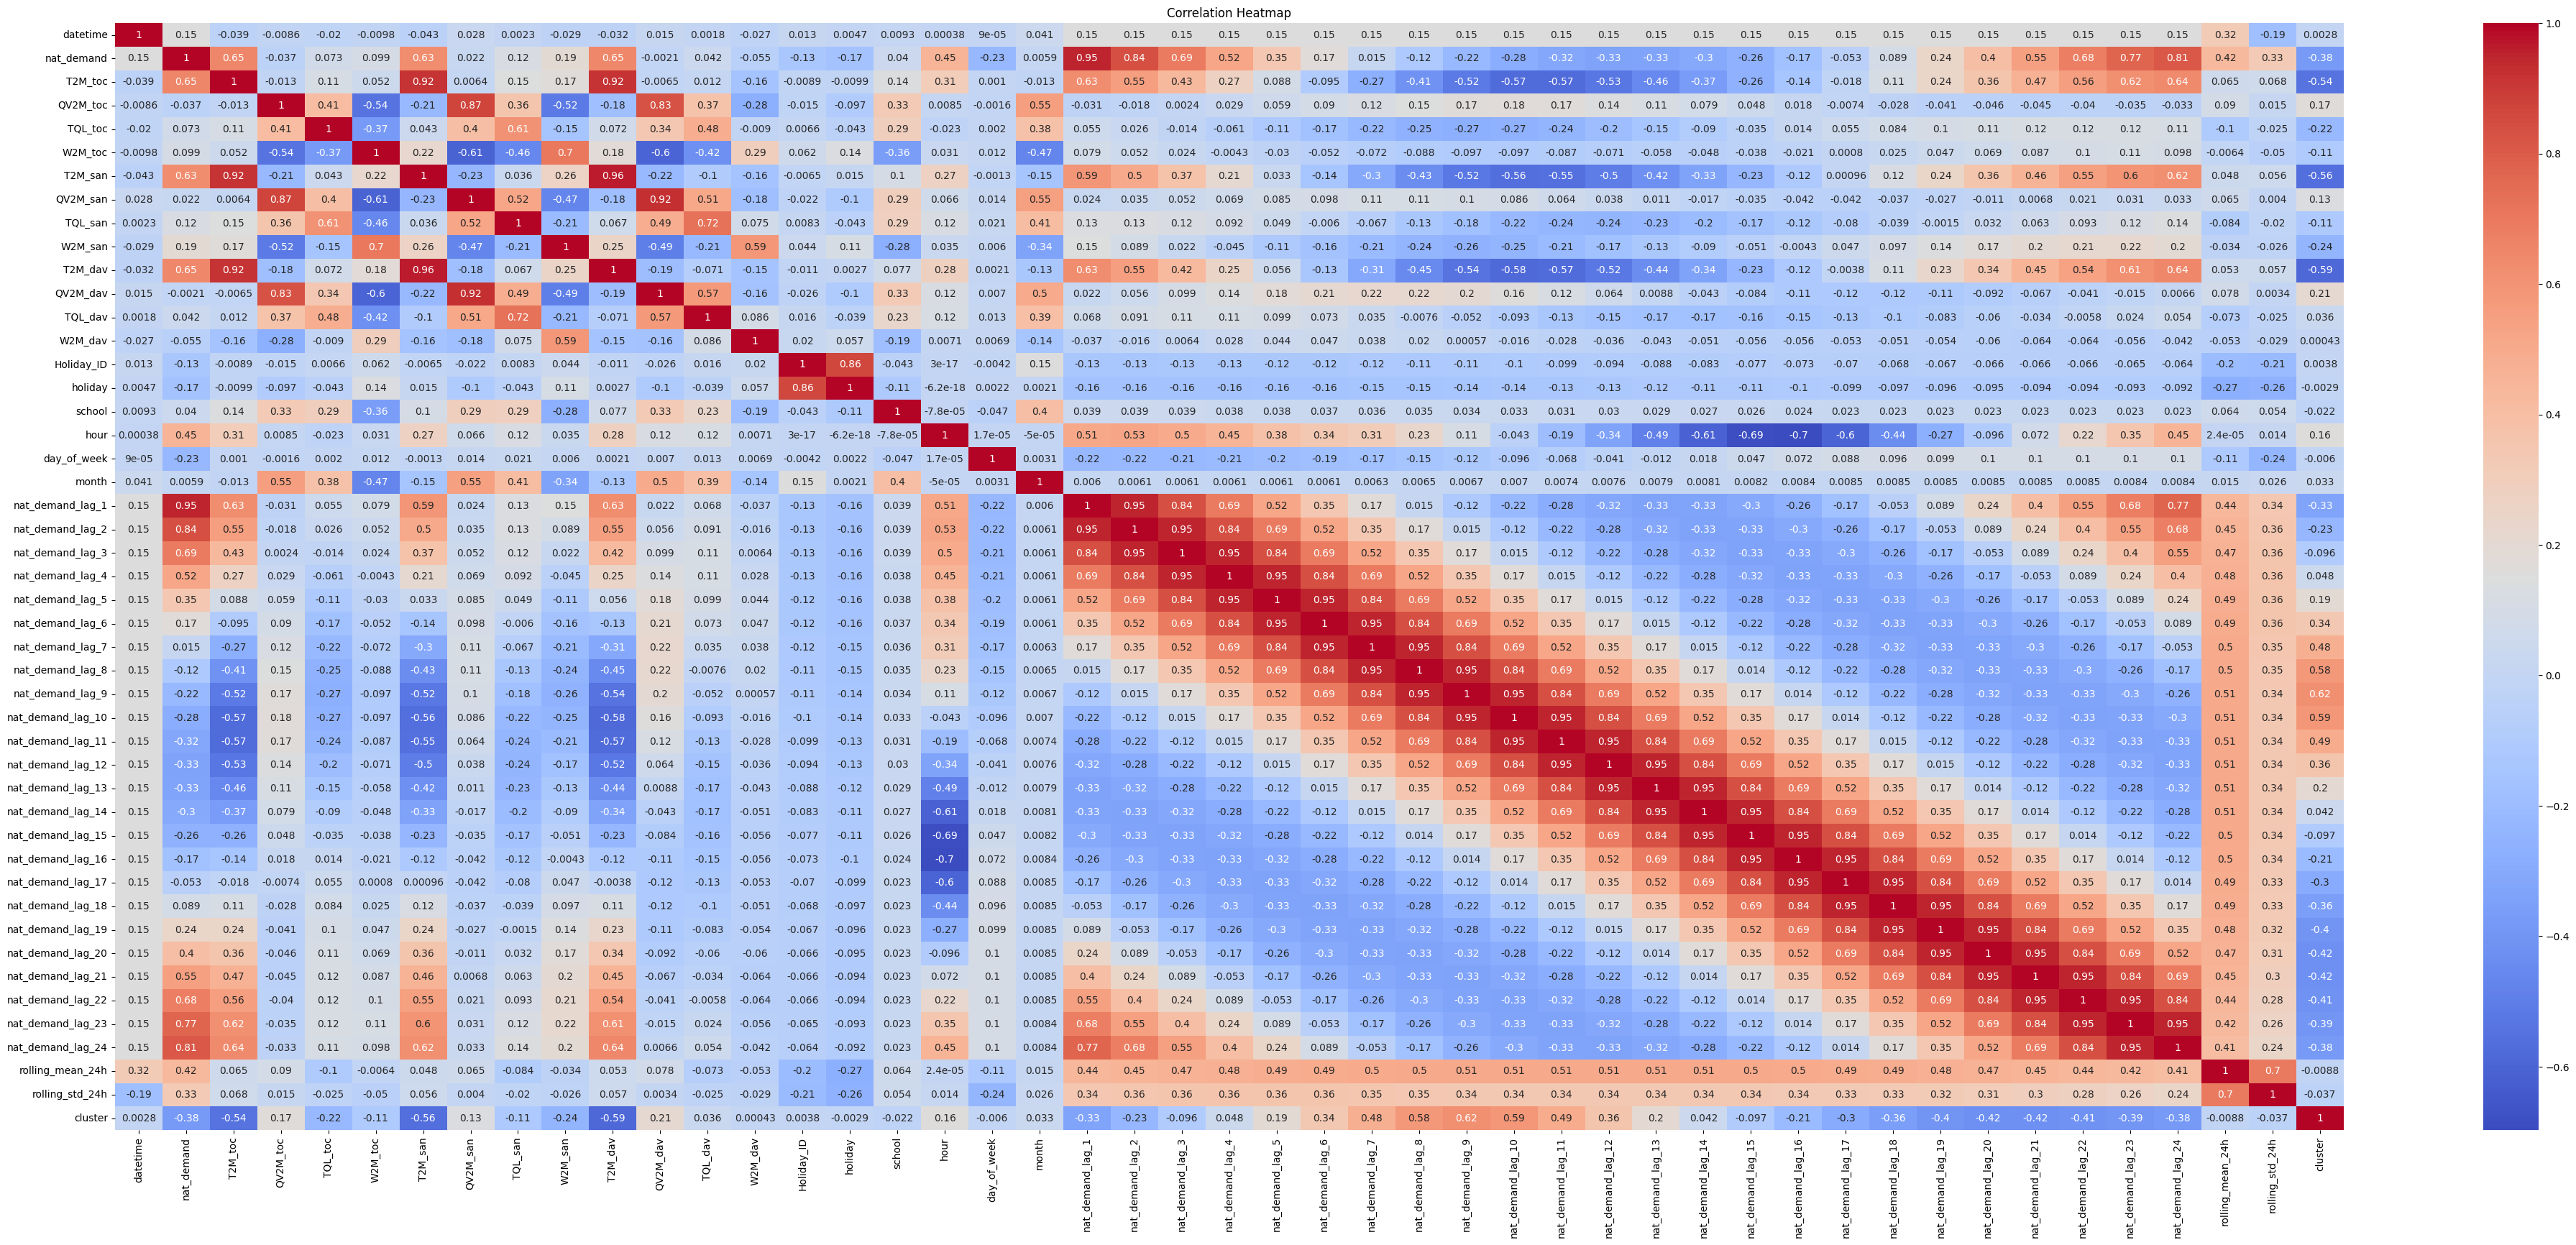

In [12]:
# 2. Correlation Heatmap
plt.figure(figsize=(50, 20))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

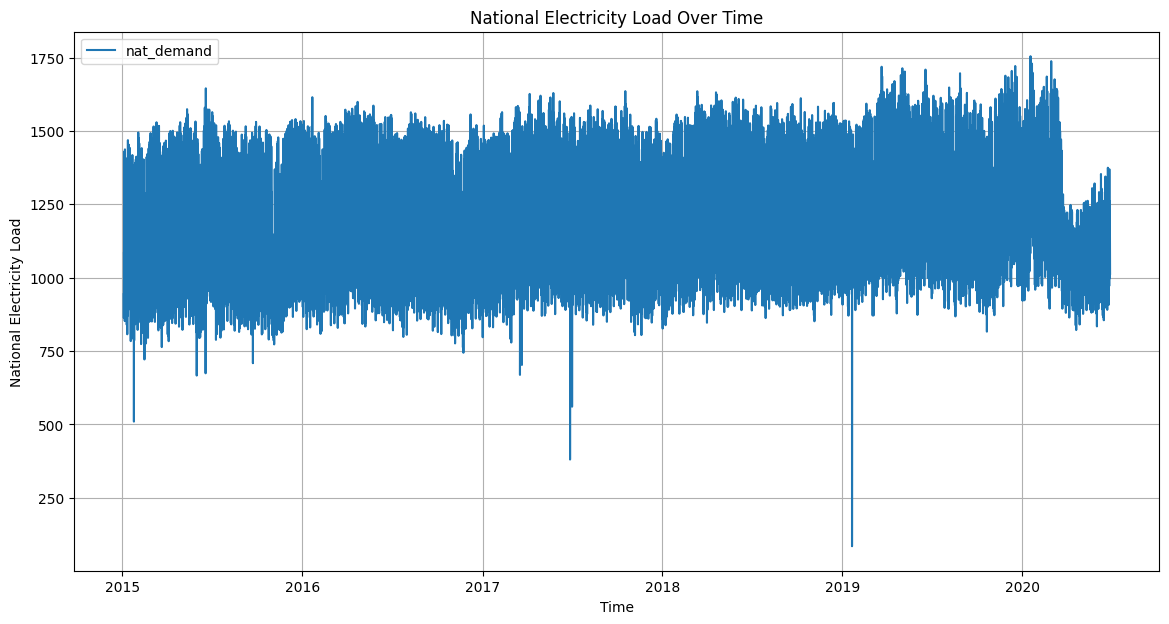

In [13]:
# 3. Line Plot of nat_demand over time
plt.figure(figsize=(14, 7))
plt.plot(data['datetime'], data['nat_demand'], label='nat_demand')
plt.title('National Electricity Load Over Time')
plt.xlabel('Time')
plt.ylabel('National Electricity Load')
plt.legend()
plt.grid(True)
plt.show()

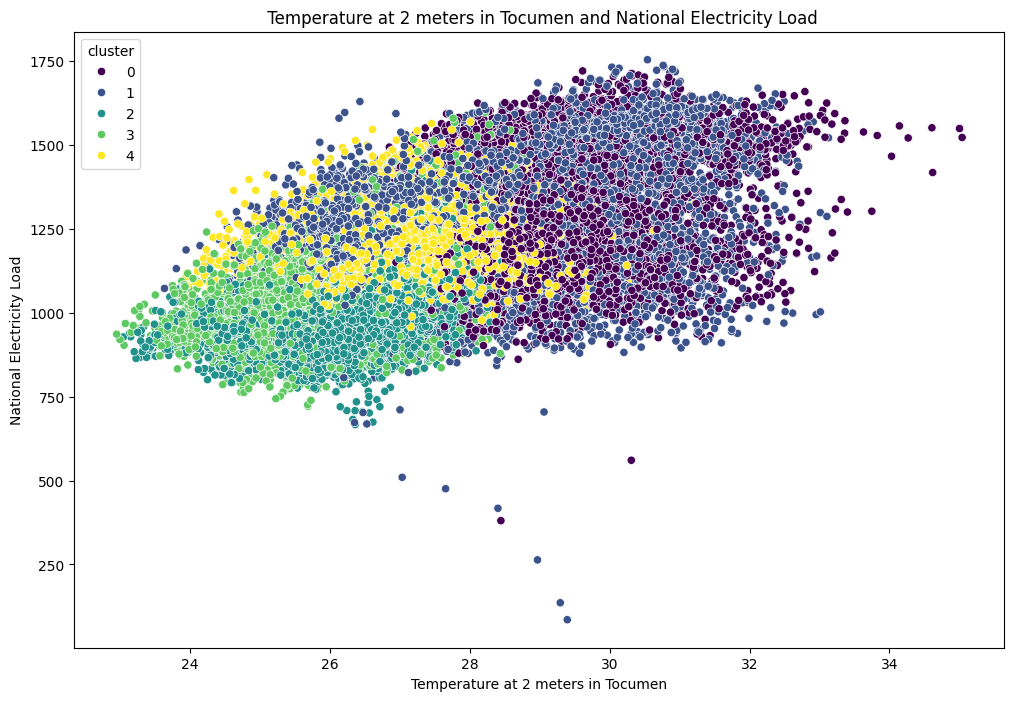

In [14]:
# Analyze clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x=data['T2M_toc'], y=data['nat_demand'], hue=data['cluster'], palette='viridis')
plt.title(' Temperature at 2 meters in Tocumen and National Electricity Load')
plt.xlabel('Temperature at 2 meters in Tocumen')
plt.ylabel('National Electricity Load')
plt.show()

In [15]:
# Prepare the data for modeling
X = data.drop(columns=['datetime', 'nat_demand'])
y = data['nat_demand']

In [16]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [17]:


# Hyperparameter tuning for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

Fitting 3 folds for each of 243 candidates, totalling 729 fits


C:\Users\Adarsh Sharma\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Root Mean Squared Error: 19.28330665859228


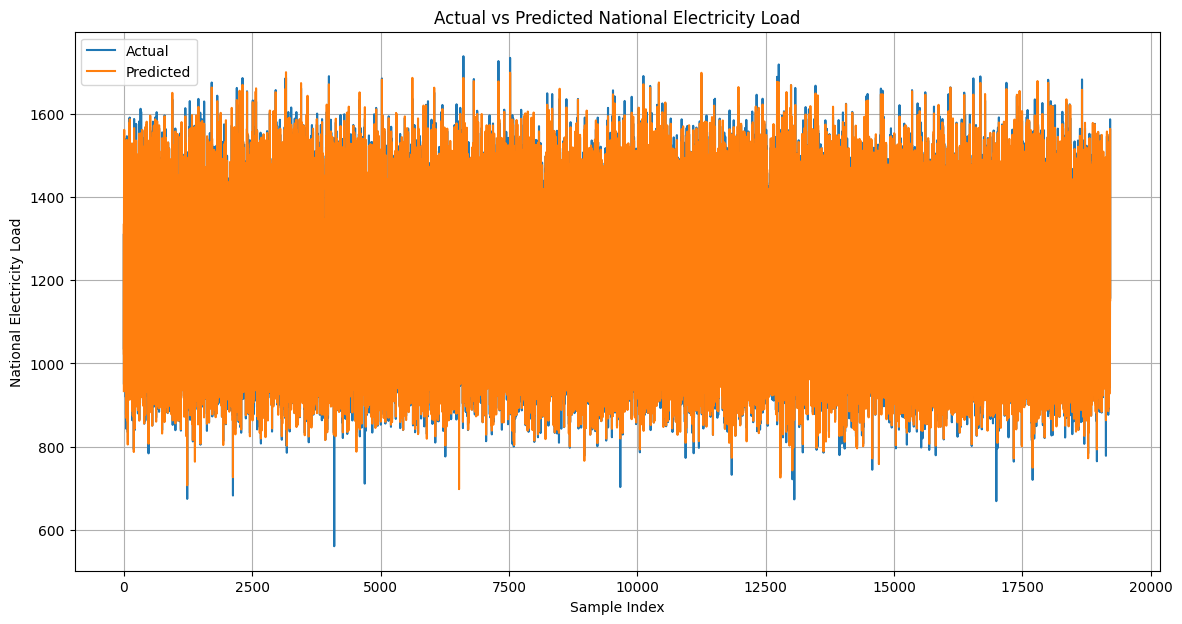

In [18]:


# Evaluate the best model
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse}')

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('National Electricity Load')
plt.title('Actual vs Predicted National Electricity Load')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# Calculate the average national electricity load
average_nat_demand = data['nat_demand'].mean()

# Calculate the percentage RMSE
percentage_rmse = (rmse / average_nat_demand) * 100

print(f'Average National Electricity Load: {average_nat_demand}')
print(f'Percentage RMSE: {percentage_rmse:.2f}%')

Average National Electricity Load: 1182.9275274471959
Percentage RMSE: 1.63%


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming y_test contains the true values and y_pred contains the predicted values
# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Display the metrics
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")


Root Mean Squared Error (RMSE): 19.28
Mean Absolute Error (MAE): 12.91
R-squared (R²): 0.99


C:\Users\Adarsh Sharma\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [21]:
# Calculate the mean of the true values
mean_y_test = y_test.mean()

# Calculate the accuracy percentage
accuracy_percentage = (1 - (rmse / mean_y_test)) * 100

# Print the accuracy percentage
print(f"Model Accuracy: {accuracy_percentage:.2f}%")


Model Accuracy: 98.37%


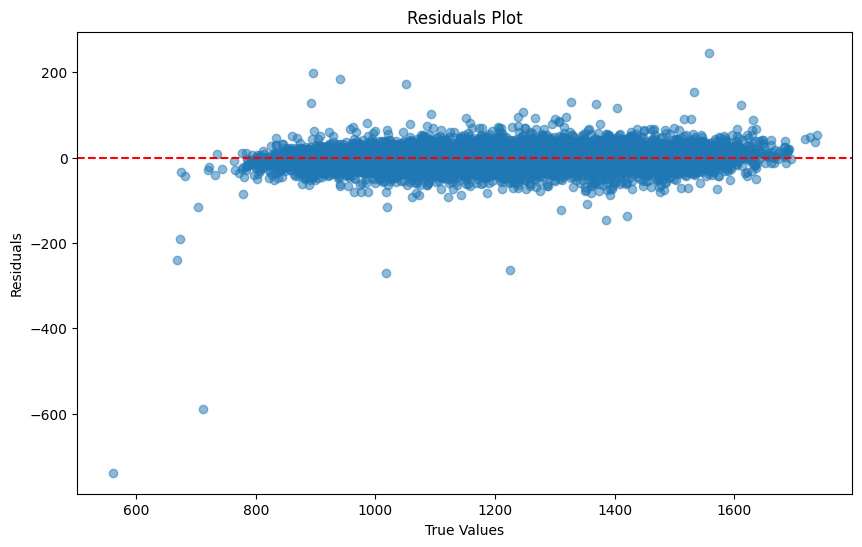

In [22]:
import matplotlib.pyplot as plt
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals Plot')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.show()
